# Fashion Style Recommendations
> Creating using different Data Science methods, best recommendations for the members.

- toc: true 
- badges: true
- comments: true
- categories: [recommendation systems,jupyter]
- image: images/chart-preview.png

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
!nvidia-smi

Tue Mar  2 13:12:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# INTRO
First we divide the data into 4 types: 

*   counts , product and user
*   user info
*   product info
*   mix of user and product info


In [5]:
import os

In [6]:
os.chdir('drive/My Drive')

In [7]:
import pandas as pd

In [8]:
data=pd.read_csv('use_case.rpt',sep=';')

In [9]:
data.head()

,ProductID,MEMBERID,Colour,matherial,product_group,target_group,features,Category,Cluster,gender,age
0,010CA1O304,147522.0,OTHER,Cotton,Accessories,Women,backpack,Accessories hard,Bags Non-Leather,2.0,43.0
1,010CA1O304,3755899.0,NAVY,Cotton,Accessories,Women,backpack,Accessories hard,Bags Non-Leather,2.0,58.0
2,010CA1O304,6326114.0,BLUE,Cotton,Accessories,Women,backpack,Accessories hard,Bags Non-Leather,2.0,52.0
3,010CA1Q302,9539278.0,BLUE,Polyester,Accessories,Women,shawls,Accessories soft,Shawls/Scarves,2.0,44.0
4,010CA1S301,1621111.0,BLUE,Buffalo Split Leather,Accessories,Women,belts cm,Accessories hard,Belts,2.0,52.0


In [10]:
collabFiltering=data.groupby(['MEMBERID','ProductID']).count().reset_index()[['MEMBERID','ProductID','Colour']].rename(columns={"Colour": "Count"})

In [11]:
userData=data.drop_duplicates('MEMBERID')[['gender','age','MEMBERID']].dropna()

We extract two extra metrics like number of buys and unique buys for product and user data both.

In [12]:
userData['Buys'] = userData['MEMBERID'].map(data.groupby('MEMBERID')['ProductID'].count())
userData['UniqueBuys'] = userData['MEMBERID'].map(data.groupby('MEMBERID')['ProductID'].nunique())

In [ ]:
userData.head()

,gender,age,MEMBERID,Buys,UniqueBuys
0,2.0,43.0,147522.0,24,8
1,2.0,58.0,3755899.0,10,2
2,2.0,52.0,6326114.0,8,3
3,2.0,44.0,9539278.0,4,2
4,2.0,52.0,1621111.0,11,4


In [13]:
productData=data.drop_duplicates('ProductID').drop(columns=['gender','age','MEMBERID'],axis=1).dropna()

In [14]:
productData['Buys'] = productData['ProductID'].map(data.groupby('ProductID')['MEMBERID'].count())
productData['UniqueBuys'] = productData['ProductID'].map(data.groupby('ProductID')['MEMBERID'].nunique())

In [ ]:
productData.head()

,ProductID,Colour,matherial,product_group,target_group,features,Category,Cluster,Buys,UniqueBuys
0,010CA1O304,OTHER,Cotton,Accessories,Women,backpack,Accessories hard,Bags Non-Leather,12,4
3,010CA1Q302,BLUE,Polyester,Accessories,Women,shawls,Accessories soft,Shawls/Scarves,4,2
4,010CA1S301,BLUE,Buffalo Split Leather,Accessories,Women,belts cm,Accessories hard,Belts,117,37
18,010CC1B302,GREY,Cotton,Women,Women,length service,Denim,Pants Denim,280,140
48,010CC1B305,OTHER,Cotton,Women,Women,length service,Denim,Pants Denim,544,272


# Data Exploration

In [ ]:
import seaborn as sns

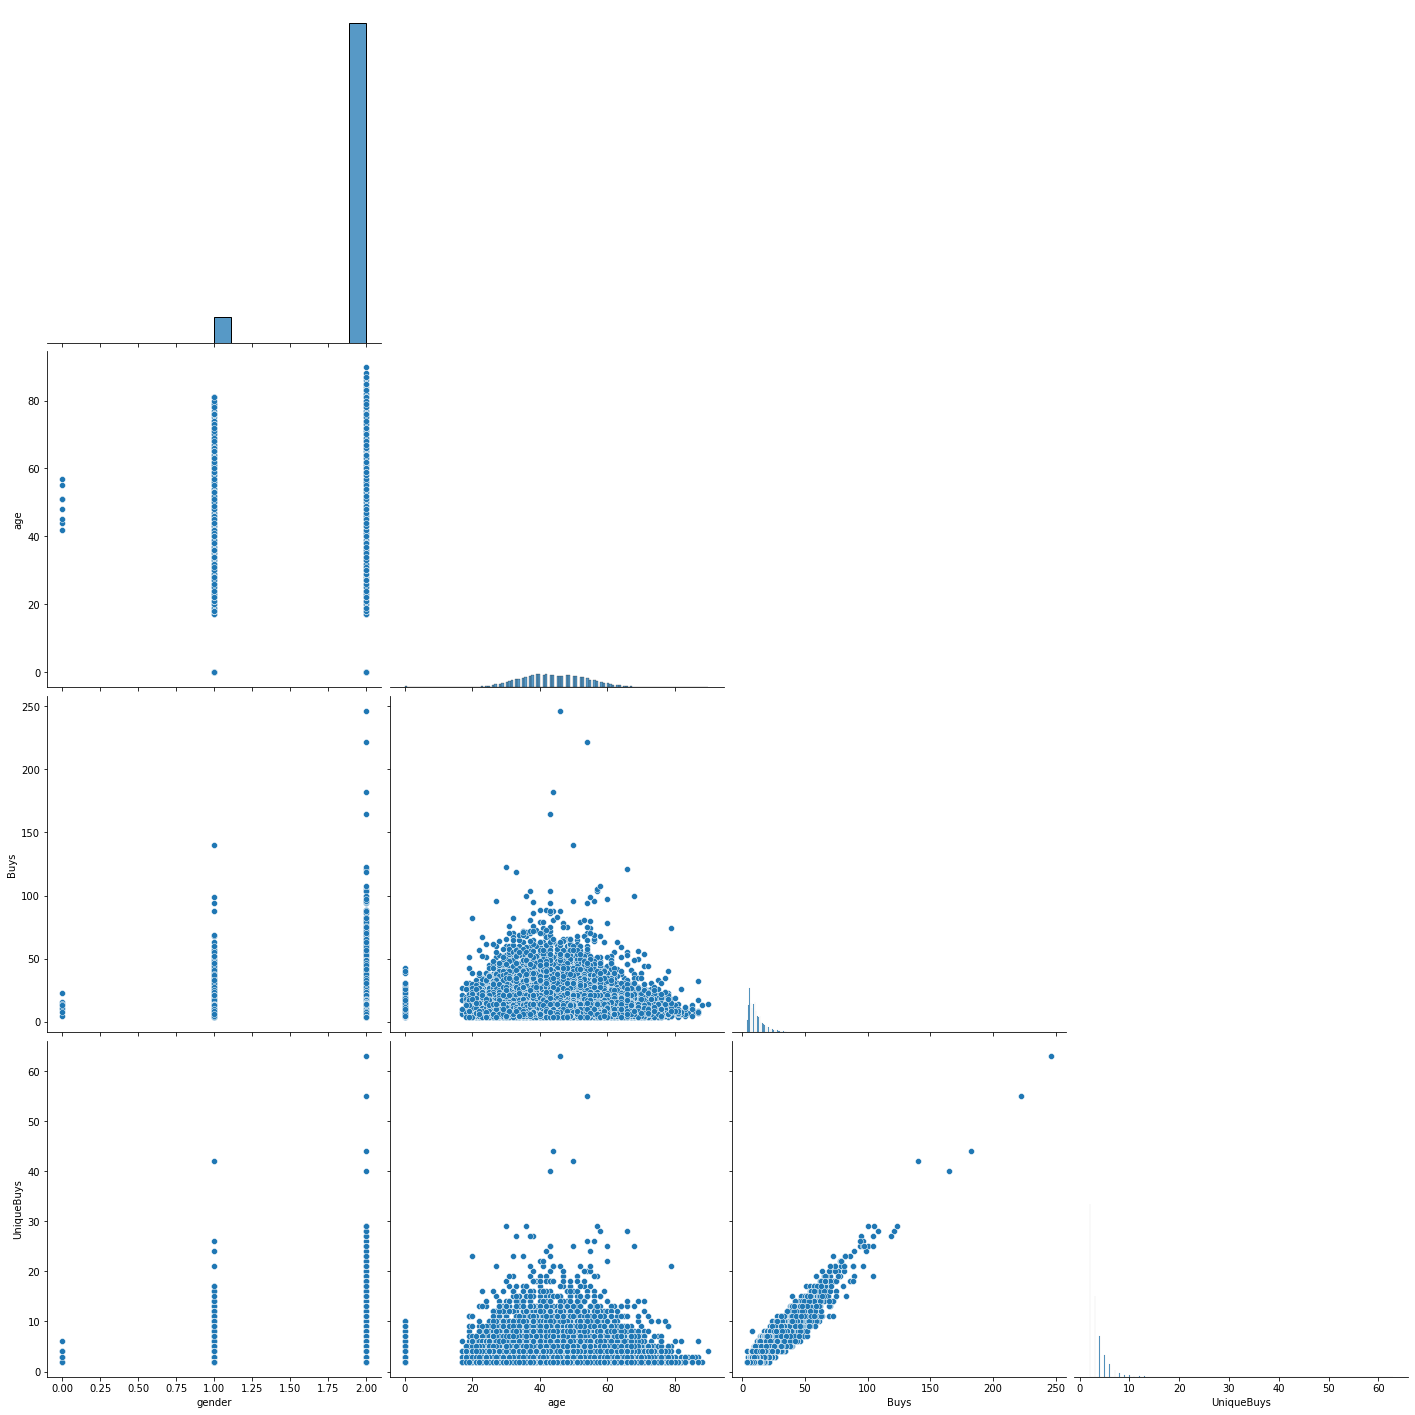

In [ ]:
sns.pairplot(userData[['gender','age','Buys','UniqueBuys']], height=5,corner=True)

ages are spread between 20 and 60. Moreover we see mid aged people buy more. Gender wise we see gender 2 to be more acitive in purchase activites.

 below we can see the count distributions for categorical columns which we have.

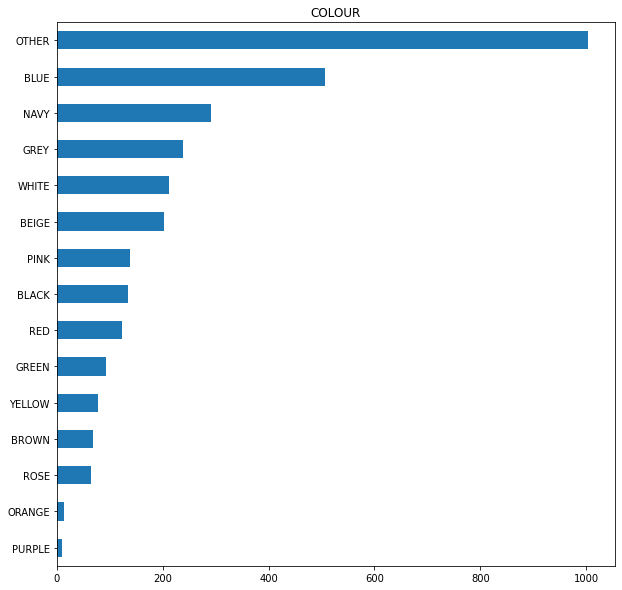

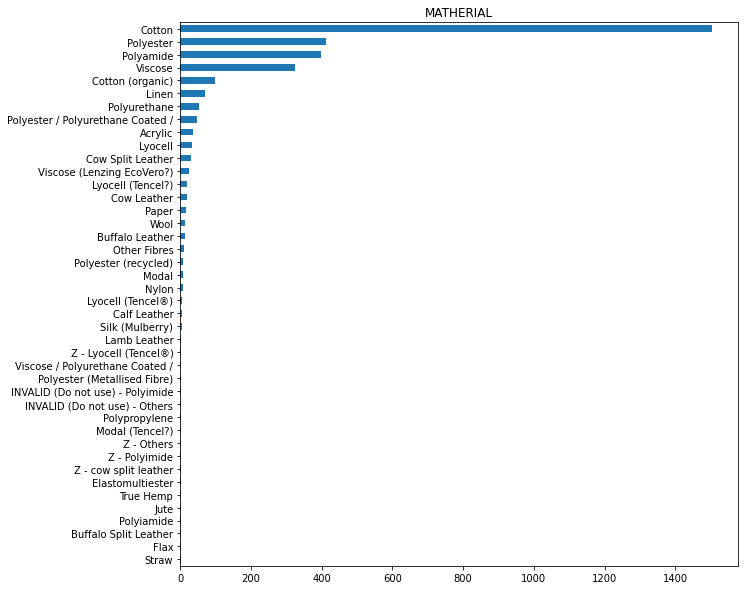

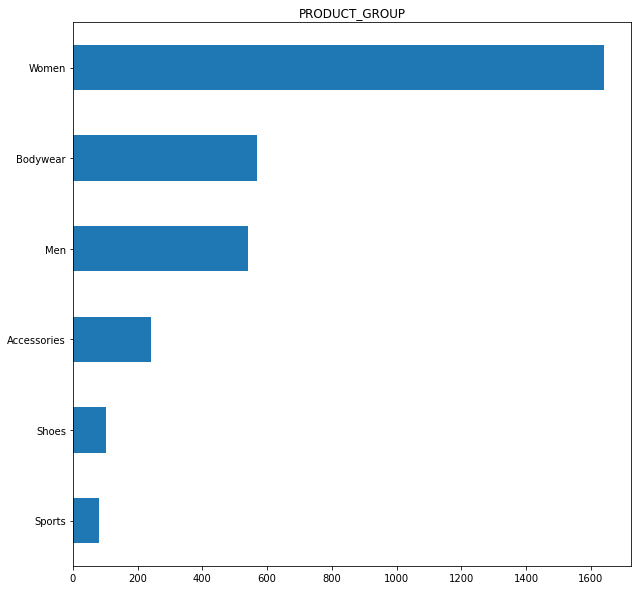

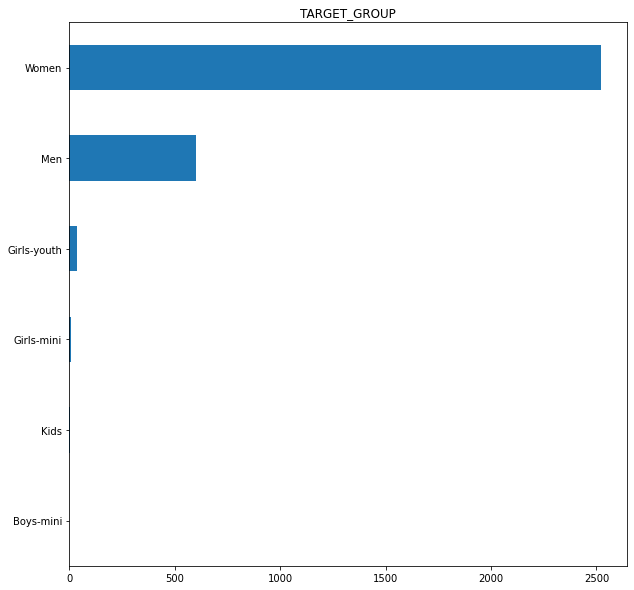

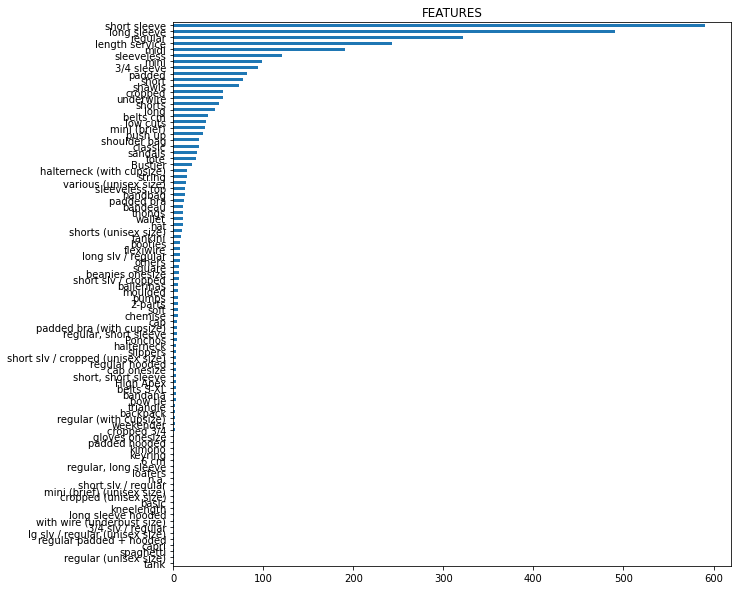

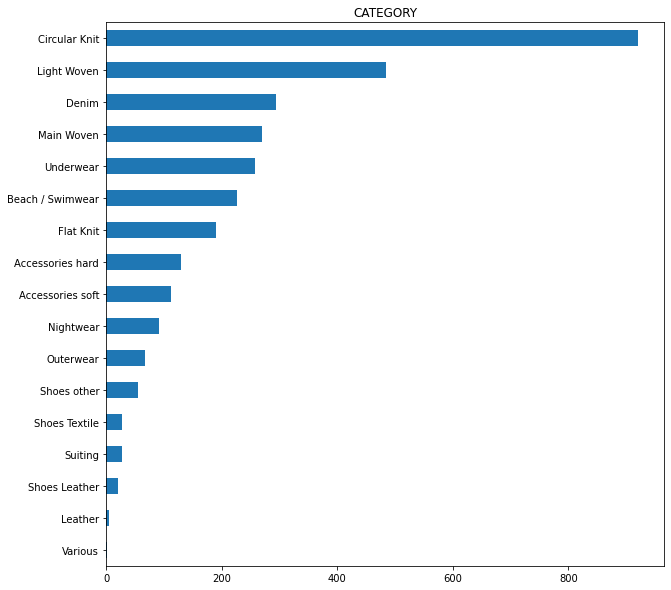

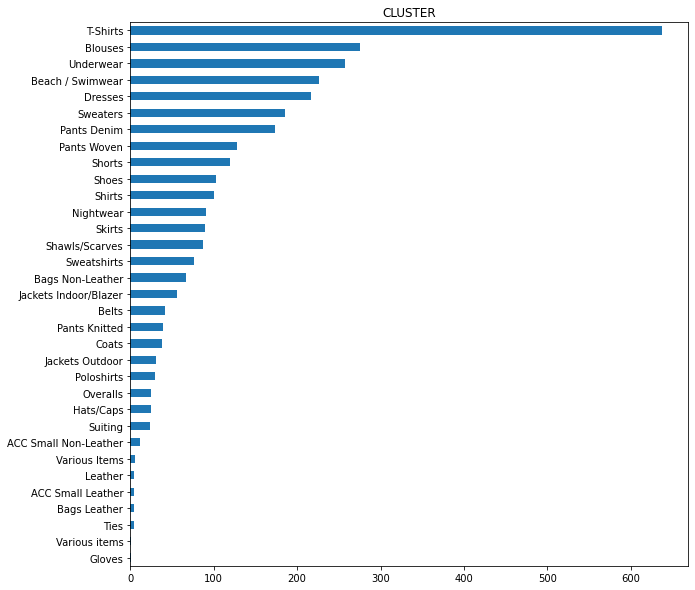

In [ ]:
import matplotlib.pyplot as plt

for col in productData.columns[1:-2]:
  plt.rcParams["figure.figsize"] = (10,10)
  productData[col].value_counts(ascending=True).plot(kind='barh')
  plt.title(col.upper())
  plt.show()

In [ ]:
productData.head()

,ProductID,Colour,matherial,product_group,target_group,features,Category,Cluster,Buys,UniqueBuys
0,010CA1O304,OTHER,Cotton,Accessories,Women,backpack,Accessories hard,Bags Non-Leather,12,4
3,010CA1Q302,BLUE,Polyester,Accessories,Women,shawls,Accessories soft,Shawls/Scarves,4,2
4,010CA1S301,BLUE,Buffalo Split Leather,Accessories,Women,belts cm,Accessories hard,Belts,117,37
18,010CC1B302,GREY,Cotton,Women,Women,length service,Denim,Pants Denim,280,140
48,010CC1B305,OTHER,Cotton,Women,Women,length service,Denim,Pants Denim,544,272


from below we can understand t shirts and pants woven were the favourite choices.

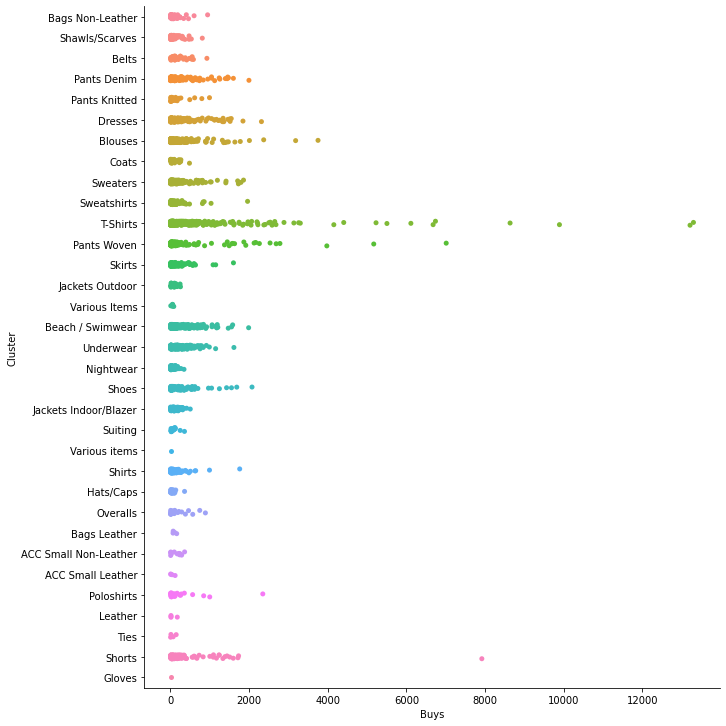

In [ ]:
sns.catplot(x="Buys", y="Cluster", data=productData,orient='h', height=10)

# Clustering




Clustering user and produc groups.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn import datasets
import numpy as np

In [ ]:
def select_n_components(var_ratio, goal_var):
    total_variance = 0
    n_components = 0
    for explained_variance in var_ratio:
        total_variance += explained_variance
        n_components += 1
        if total_variance >= goal_var:
            break
    return n_components

In [ ]:
onehotprods=pd.get_dummies(productData.drop(['ProductID','Buys','UniqueBuys'],axis=1), drop_first=True)
X_sparse = csr_matrix(onehotprods)
tsvd = TruncatedSVD(n_components=X_sparse.shape[1]-1)
X_tsvd = tsvd.fit(X_sparse)
comps=select_n_components( tsvd.explained_variance_ratio_ , 0.95)

In [ ]:
from sklearn.preprocessing import normalize
userDataNorm=normalize(userData[['gender','age','Buys','UniqueBuys']], norm='l2')
prods=TruncatedSVD(n_components=comps).fit_transform(X_sparse)
productDataNorm=normalize(prods, norm='l2')

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score,silhouette_score

In [ ]:
import numpy as np

In [ ]:
def cluster(datascaled):
  scoresDBIndex=[]
  scoresElbow=[]
  scoresSilhoutte=[]
  for i in range(2,20):
    kmeans = KMeans(n_clusters=i, random_state=0,n_jobs=-1).fit(datascaled)
    datafull=np.column_stack((datascaled,kmeans.labels_))
    scoresDBIndex.append(round(davies_bouldin_score(datafull[:,:-1],datafull[:,-1]),2))
    scoresElbow.append(round(kmeans.inertia_,2))
    scoresSilhoutte.append(round(silhouette_score(datafull[:,:-1],datafull[:,-1]),2))
  return scoresDBIndex,scoresElbow,scoresSilhoutte

In [ ]:
%%time
resUser=cluster(userDataNorm)

CPU times: user 14min 48s, sys: 1min 39s, total: 16min 28s
Wall time: 12min 17s


In [ ]:
%%time
resProd=cluster(productDataNorm)

CPU times: user 21.1 s, sys: 12.7 s, total: 33.7 s
Wall time: 17.3 s


In [ ]:
import matplotlib.pyplot as plt

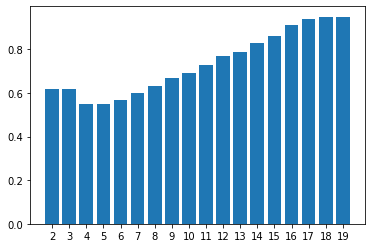

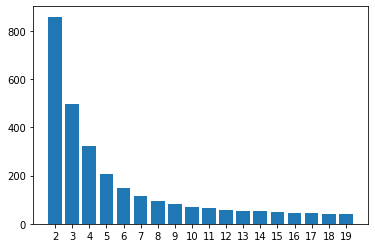

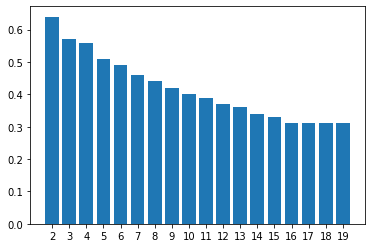

In [ ]:
for metric in resUser:
  plt.xticks(np.array(range(len(metric)))+2)
  plt.bar(x=np.array(range(len(metric)))+2,height=metric)
  plt.show()

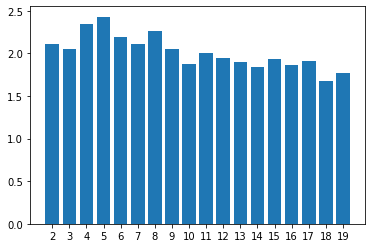

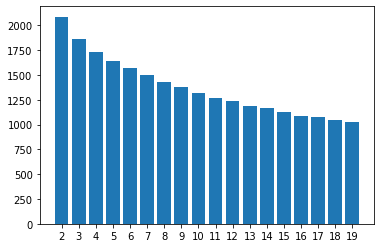

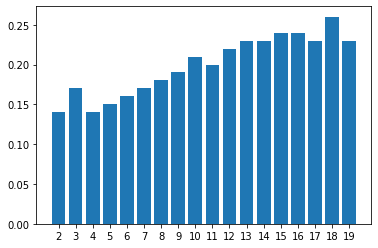

In [ ]:
for metric in resProd:
  plt.xticks(np.array(range(len(metric)))+2)
  plt.bar(x=np.array(range(len(metric)))+2,height=metric)
  plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0,n_jobs=-1).fit(userDataNorm)
dataUser=np.column_stack((userDataNorm,kmeans.labels_))

In [ ]:
kmeans = KMeans(n_clusters=18, random_state=0,n_jobs=-1).fit(productDataNorm)
dataProds=np.column_stack((productDataNorm,kmeans.labels_))

In [ ]:
import seaborn as sns

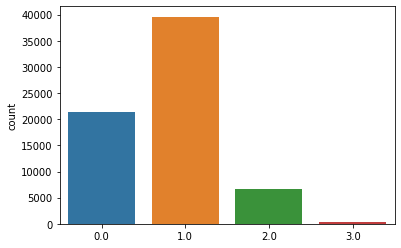

In [ ]:
sns.countplot(dataUser[:,-1])

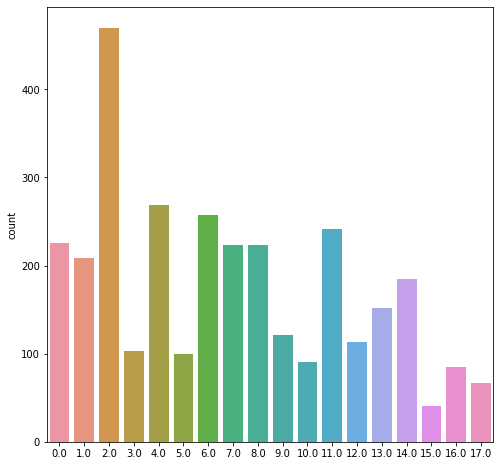

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
sns.countplot(dataProds[:,-1],ax=ax)

# Popularity based recommender system

In [ ]:
probs=getPopularProducts(20)

In [ ]:
topProds={}
def getPopularProducts(n):
  for i in range(4):
    users=dataUser[:,-1]==i
    uniqueProds=collabFiltering['MEMBERID'].isin(userData[users]['MEMBERID'].values)
    topProds[i]=collabFiltering[uniqueProds].groupby('ProductID')['Count'].sum().reset_index().sort_values(by='Count',ascending=False)[:n]['ProductID'].values
    probs=collabFiltering[uniqueProds].groupby('ProductID')['Count'].sum().reset_index().sort_values(by='Count',ascending=False)[:n]['Count'].values
    probs=probs/probs.sum()
  return probs

In [ ]:
def getPredsForUser(topProds,user,probs,topN):
  indx=userData['MEMBERID']==user
  cluster=dataUser[indx,-1]
  return np.random.choice(a=topProds[int(cluster)],size=topN,p=probs)

In [ ]:
getPredsForUser(topProds,178765,probs,5)

array(['020EO1B314', '040EE1K418', '030EO1B310', '020EE1K308',
       '020EE1K309'], dtype=object)

In [ ]:
getPredsForUser(topProds,771733,probs,5)

array(['020EE1K311', '990EE1B303', '030EO1B308', '990EE1B303',
       '040EE1K418'], dtype=object)

In [ ]:
!pip install wandb -q

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
The folder you are executing pip from can no longer be found.


In [ ]:
userData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67872 entries, 0 to 786187
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gender    67872 non-null  float64
 1   age       67872 non-null  float64
 2   MEMBERID  67872 non-null  float64
dtypes: float64(3)
memory usage: 2.1 MB


In [15]:
combinedData=collabFiltering.set_index('MEMBERID').join(userData.drop(columns=['Buys', 'UniqueBuys'],axis=1).set_index('MEMBERID')).reset_index().set_index('ProductID').join(productData.drop(columns=['Buys', 'UniqueBuys'],axis=1).set_index('ProductID')).reset_index()

# xDeepFM

Factorization based models, which measure
interactions in terms of vector product, can learn patterns of combinatorial features automatically and generalize to unseen features
as well. With the great success of deep neural networks (DNNs)
in various fields, recently researchers have proposed several DNNbased factorization model to learn both low- and high-order feature
interactions. Despite the powerful ability of learning an arbitrary
function from data, plain DNNs generate feature interactions implicitly and at the bit-wise level. In this paper, we propose a novel
Compressed Interaction Network (CIN), which aims to generate
feature interactions in an explicit fashion and at the vector-wise
level. We further combine a CIN and a classical DNN into one
unified model, and named this new model eXtreme Deep Factorization Machine (xDeepFM). On one hand, the xDeepFM is able
to learn certain bounded-degree feature interactions explicitly; on
the other hand, it can learn arbitrary low- and high-order feature
interactions implicitly

In [16]:
!pip install deepctr

     |████████████████████████████████| 122kB 5.3MB/s 


In [17]:
!pip install pytorch-tabnet

In [18]:
collabFiltering.nunique()

MEMBERID     67872
ProductID     3302
Count           14
dtype: int64

In [19]:
combinedData.nunique()

ProductID         3302
MEMBERID         67872
Count               14
gender               3
age                 74
Colour              15
matherial           42
product_group        6
target_group         6
features            90
Category            17
Cluster             33
dtype: int64

In [ ]:
178765,771733

(178765, 771733)

In [20]:
user178765=userData[userData['MEMBERID']==178765].drop(columns=['Buys', 'UniqueBuys'],axis=1).assign(foo=1).merge(productData.drop(columns=['Buys', 'UniqueBuys'],axis=1).assign(foo=1)).drop('foo', 1)

In [21]:
preds178765=user178765.copy()

In [22]:
user771733=userData[userData['MEMBERID']==771733].drop(columns=['Buys', 'UniqueBuys'],axis=1).assign(foo=1).merge(productData.drop(columns=['Buys', 'UniqueBuys'],axis=1).assign(foo=1)).drop('foo', 1)

In [23]:
preds771733=user771733.copy()

In [24]:
combinedData.head()

,ProductID,MEMBERID,Count,gender,age,Colour,matherial,product_group,target_group,features,Category,Cluster
0,010CA1O304,147522.0,3,2.0,43.0,OTHER,Cotton,Accessories,Women,backpack,Accessories hard,Bags Non-Leather
1,010CA1O304,3755899.0,3,2.0,58.0,OTHER,Cotton,Accessories,Women,backpack,Accessories hard,Bags Non-Leather
2,010CA1O304,6273937.0,3,2.0,40.0,OTHER,Cotton,Accessories,Women,backpack,Accessories hard,Bags Non-Leather
3,010CA1O304,6326114.0,3,2.0,52.0,OTHER,Cotton,Accessories,Women,backpack,Accessories hard,Bags Non-Leather
4,010CA1Q302,828374.0,2,2.0,33.0,BLUE,Polyester,Accessories,Women,shawls,Accessories soft,Shawls/Scarves


In [25]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

from deepctr.models import xDeepFM
from deepctr.feature_column import SparseFeat,get_feature_names,DenseFeat

In [26]:
lbegender = LabelEncoder()
mnmxAge=MinMaxScaler(feature_range=(0, 1))
lbeMEMBERID = LabelEncoder()
lbeProductID = LabelEncoder()
lbeColour = LabelEncoder()
lbematherial = LabelEncoder()
lbeproduct_group = LabelEncoder()
lbetarget_group = LabelEncoder()
lbefeatures = LabelEncoder()
lbeCategory = LabelEncoder()
lbeCluster = LabelEncoder()

In [27]:
categorical_dims =  {}

In [28]:
def feature_encoding(lbegender,mnmxAge,lbeMEMBERID,lbeProductID,lbeColour,lbematherial,lbeproduct_group,lbetarget_group,lbefeatures,lbeCategory,lbeCluster,fit,data,categorical_dims):
    if(fit==1):
      data['gender']=data['gender'].astype(str)
      lbegender.fit(data[['gender']].values)
      data['gender'] = lbegender.transform(data[['gender']].values)
      categorical_dims['gender'] = len(lbegender.classes_)

      mnmxAge.fit(data[['age']].values)
      data['age'] = mnmxAge.transform(data[['age']].values)

      data['MEMBERID']=data['MEMBERID'].astype(str)
      lbeMEMBERID.fit(data[['MEMBERID']].values)
      data['MEMBERID'] = lbeMEMBERID.transform(data[['MEMBERID']].values)
      categorical_dims['MEMBERID'] = len(lbeMEMBERID.classes_)

      data['ProductID']=data['ProductID'].astype(str)
      lbeProductID.fit(data[['ProductID']].values)
      data['ProductID'] = lbeProductID.transform(data[['ProductID']].values)
      categorical_dims['ProductID'] = len(lbeProductID.classes_)

      data['Colour']=data['Colour'].astype(str)
      lbeColour.fit(data[['Colour']].values)
      data['Colour'] = lbeColour.transform(data[['Colour']].values)
      categorical_dims['Colour'] = len(lbeColour.classes_)

      data['matherial']=data['matherial'].astype(str)
      lbematherial.fit(data[['matherial']].values)
      data['matherial'] = lbematherial.transform(data[['matherial']].values)
      categorical_dims['matherial'] = len(lbematherial.classes_)

      data['product_group']=data['product_group'].astype(str)
      lbeproduct_group.fit(data[['product_group']].values)
      data['product_group'] = lbeproduct_group.transform(data[['product_group']].values)
      categorical_dims['product_group'] = len(lbeproduct_group.classes_)


      data['target_group']=data['target_group'].astype(str)
      lbetarget_group.fit(data[['target_group']].values)
      data['target_group'] = lbetarget_group.transform(data[['target_group']].values)
      categorical_dims['target_group'] = len(lbetarget_group.classes_)

      data['features']=data['features'].astype(str)
      lbefeatures.fit(data[['features']].values)
      data['features'] = lbefeatures.transform(data[['features']].values)
      categorical_dims['features'] = len(lbefeatures.classes_)

      data['Category']=data['Category'].astype(str)
      lbeCategory.fit(data[['Category']].values)
      data['Category'] = lbeCategory.transform(data[['Category']].values)
      categorical_dims['Category'] = len(lbeCategory.classes_)

      data['Cluster']=data['Cluster'].astype(str)
      lbeCluster.fit(data[['Cluster']].values)
      data['Cluster'] = lbeCluster.transform(data[['Cluster']].values)
      categorical_dims['Cluster'] = len(lbeCluster.classes_)

    else:
      data['gender']=data['gender'].astype(str)
      data['gender'] = lbegender.transform(data[['gender']].values)
      data['age']=data['age'].astype(int)
      data['age'] = mnmxAge.transform(data[['age']].values)
      data['MEMBERID']=data['MEMBERID'].astype(str)
      data['MEMBERID'] = lbeMEMBERID.transform(data[['MEMBERID']].values)
      data['ProductID']=data['ProductID'].astype(str)
      data['ProductID'] = lbeProductID.transform(data[['ProductID']].values)
      data['Colour']=data['Colour'].astype(str)
      data['Colour'] = lbeColour.transform(data[['Colour']].values)
      data['matherial']=data['matherial'].astype(str)
      data['matherial'] = lbematherial.transform(data[['matherial']].values)
      data['product_group']=data['product_group'].astype(str)
      data['product_group'] = lbeproduct_group.transform(data[['product_group']].values)
      data['target_group']=data['target_group'].astype(str)
      data['target_group'] = lbetarget_group.transform(data[['target_group']].values)
      data['features']=data['features'].astype(str)
      data['features'] = lbefeatures.transform(data[['features']].values)
      data['Category']=data['Category'].astype(str)
      data['Category'] = lbeCategory.transform(data[['Category']].values)
      data['Cluster']=data['Cluster'].astype(str)
      data['Cluster'] = lbeCluster.transform(data[['Cluster']].values)


In [29]:
data=combinedData.copy()

In [30]:
feature_encoding(lbegender,mnmxAge,lbeMEMBERID,lbeProductID,lbeColour,lbematherial,lbeproduct_group,lbetarget_group,lbefeatures,lbeCategory,lbeCluster,1,data,categorical_dims)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

In [31]:
from keras.optimizers import Adam

In [32]:
sparse_features = ["MEMBERID", "ProductID","gender",  "Colour", "matherial",'product_group','target_group','features','Category','Cluster']
dense_features = ['age']
target = ['Count']
fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique(),embedding_dim=16) for feat in sparse_features]+[DenseFeat(feat, 1,) for feat in dense_features]

linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

train, test = train_test_split(data, test_size=0.05, random_state=28)
train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}

model = xDeepFM(linear_feature_columns, dnn_feature_columns, task='regression')
model.compile(Adam(learning_rate=1e-4), "mse", metrics=['mse'])

history = model.fit(train_model_input, train[target].values,batch_size=256, epochs=2, verbose=1, validation_split=0.1)
pred_ans = model.predict(test_model_input, batch_size=256)
print("test MSE", round(mean_squared_error(test[target].values, pred_ans), 4))

Epoch 1/2
710/710 [==============================] - 36s 38ms/step - loss: 6.6033 - mse: 6.6033 - val_loss: 1.5627 - val_mse: 1.5626
Epoch 2/2
710/710 [==============================] - 26s 36ms/step - loss: 1.4131 - mse: 1.4130 - val_loss: 1.5554 - val_mse: 1.5552
test MSE 1.6104


In [ ]:
test_model_input

{'Category': array([ 3,  3, 15, ...,  7,  3,  3]),
 'Cluster': array([28, 28, 30, ...,  8, 28, 28]),
 'Colour': array([ 0,  6,  6, ...,  5,  8, 13]),
 'MEMBERID': array([55865, 48168, 66464, ...,  1085, 29943,  4402]),
 'ProductID': array([ 398, 1642, 1374, ...,  833,  395, 1810]),
 'age': array([0.6       , 0.46666667, 0.71111111, ..., 0.55555556, 0.4       ,
        0.37777778]),
 'features': array([66,  1, 71, ..., 42, 66, 66]),
 'gender': array([2, 2, 2, ..., 2, 2, 2]),
 'matherial': array([ 4,  4, 23, ..., 14,  4,  4]),
 'product_group': array([5, 5, 1, ..., 5, 5, 5]),
 'target_group': array([5, 5, 5, ..., 5, 5, 5])}

In [33]:
feature_encoding(lbegender,mnmxAge,lbeMEMBERID,lbeProductID,lbeColour,lbematherial,lbeproduct_group,lbetarget_group,lbefeatures,lbeCategory,lbeCluster,0,user178765,categorical_dims)
feature_encoding(lbegender,mnmxAge,lbeMEMBERID,lbeProductID,lbeColour,lbematherial,lbeproduct_group,lbetarget_group,lbefeatures,lbeCategory,lbeCluster,0,user771733,categorical_dims)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
test_model_input178765 = {name:user178765[name].values for name in feature_names}
results178765=model.predict(test_model_input178765)
test_model_input771733 = {name:user771733[name].values for name in feature_names}
results771733=model.predict(test_model_input771733)

In [35]:
preds178765['PredsxDeepFM']=results178765

In [36]:
preds771733['PredsxDeepFM']=results771733

In [37]:
preds178765.head()

,gender,age,MEMBERID,ProductID,Colour,matherial,product_group,target_group,features,Category,Cluster,PredsxDeepFM
0,2.0,51.0,178765.0,010CA1O304,OTHER,Cotton,Accessories,Women,backpack,Accessories hard,Bags Non-Leather,2.237521
1,2.0,51.0,178765.0,010CA1Q302,BLUE,Polyester,Accessories,Women,shawls,Accessories soft,Shawls/Scarves,2.225422
2,2.0,51.0,178765.0,010CA1S301,BLUE,Buffalo Split Leather,Accessories,Women,belts cm,Accessories hard,Belts,2.104673
3,2.0,51.0,178765.0,010CC1B302,GREY,Cotton,Women,Women,length service,Denim,Pants Denim,1.536121
4,2.0,51.0,178765.0,010CC1B305,OTHER,Cotton,Women,Women,length service,Denim,Pants Denim,1.562388


In [38]:
preds771733.head()

,gender,age,MEMBERID,ProductID,Colour,matherial,product_group,target_group,features,Category,Cluster,PredsxDeepFM
0,2.0,42.0,771733.0,010CA1O304,OTHER,Cotton,Accessories,Women,backpack,Accessories hard,Bags Non-Leather,2.737335
1,2.0,42.0,771733.0,010CA1Q302,BLUE,Polyester,Accessories,Women,shawls,Accessories soft,Shawls/Scarves,2.690987
2,2.0,42.0,771733.0,010CA1S301,BLUE,Buffalo Split Leather,Accessories,Women,belts cm,Accessories hard,Belts,2.557454
3,2.0,42.0,771733.0,010CC1B302,GREY,Cotton,Women,Women,length service,Denim,Pants Denim,1.694690
4,2.0,42.0,771733.0,010CC1B305,OTHER,Cotton,Women,Women,length service,Denim,Pants Denim,1.722045



# TABNET

TabNet uses sequential attention to choose which features to reason
from at each decision step, enabling interpretability and more
efficient learning as the learning capacity is used for the most
salient features.

We pretrain the model then using it we train our regressor.

In [39]:
X_train = train.drop('Count',axis=1)
y_train = train['Count'].values.reshape(-1, 1)

X_valid = test.drop('Count',axis=1)
y_valid = test['Count'].values.reshape(-1, 1)

In [40]:
features = [ col for col in X_train.columns ] 

cat_idxs = [ i for i, f in enumerate(features) if f in sparse_features]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in sparse_features]


In [41]:
import torch

In [42]:
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetRegressor

In [43]:
cat_dims

[3302, 67872, 3, 16, 43, 7, 7, 91, 18, 34]

In [44]:
cat_emb_dim = [32, 64,2, 8, 8, 2,2,8, 8, 8]

In [45]:
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=cat_emb_dim,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    mask_type='entmax' # "sparsemax"
)

Device used : cuda


In [46]:
unsupervised_model.fit(
    X_train=X_train.values,
    eval_set=[X_valid.values],
    max_epochs=10 , patience=2,
    batch_size=256, virtual_batch_size=128,
    num_workers=4,
    drop_last=False,
    pretraining_ratio=0.8
)

epoch 0  | loss: 1.38828 | val_0_unsup_loss: 1.02841 |  0:00:51s
epoch 1  | loss: 1.01323 | val_0_unsup_loss: 1.00654 |  0:01:42s
epoch 2  | loss: 1.00342 | val_0_unsup_loss: 1.00144 |  0:02:34s
epoch 3  | loss: 1.00083 | val_0_unsup_loss: 0.9965  |  0:03:26s
epoch 4  | loss: 0.99586 | val_0_unsup_loss: 0.96427 |  0:04:18s
epoch 5  | loss: 0.95759 | val_0_unsup_loss: 0.91266 |  0:05:10s
epoch 6  | loss: 0.8998  | val_0_unsup_loss: 0.86415 |  0:06:01s
epoch 7  | loss: 0.85387 | val_0_unsup_loss: 0.82604 |  0:06:53s
epoch 8  | loss: 0.82051 | val_0_unsup_loss: 0.7972  |  0:07:45s
epoch 9  | loss: 0.80024 | val_0_unsup_loss: 0.7797  |  0:08:37s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_0_unsup_loss = 0.7797
Best weights from best epoch are automatically used!


In [47]:
batch_size=512
max_epochs=20
reg = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs,
                       optimizer_fn=torch.optim.Adam, # Any optimizer works here
                       optimizer_params=dict(lr=1e-3),
                       scheduler_fn=torch.optim.lr_scheduler.OneCycleLR,
                       scheduler_params={"is_batch_level":True,
                                         "max_lr":1e-3,
                                         "steps_per_epoch":int(train.shape[0] / batch_size)+1,
                                         "epochs":max_epochs
                                          },
                       mask_type='entmax')

Device used : cuda


In [48]:
reg.fit(
    X_train=X_train.values, y_train=y_train,
    eval_set=[(X_train.values, y_train), (X_valid.values, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=max_epochs,
    patience=2,
    batch_size=batch_size, virtual_batch_size=128,
    num_workers=4,
    drop_last=False
)

epoch 0  | loss: 18.91781| train_rmsle: 1.73712 | train_mae: 3.59658 | train_rmse: 4.0807  | train_mse: 16.65214| valid_rmsle: 1.75556 | valid_mae: 3.62313 | valid_rmse: 4.11499 | valid_mse: 16.93316|  0:00:38s
epoch 1  | loss: 13.38149| train_rmsle: 0.76863 | train_mae: 2.55413 | train_rmse: 3.1432  | train_mse: 9.87968 | valid_rmsle: 0.78853 | valid_mae: 2.58328 | valid_rmse: 3.18618 | valid_mse: 10.15175|  0:01:16s
epoch 2  | loss: 6.40709 | train_rmsle: 0.15214 | train_mae: 1.45646 | train_rmse: 2.01241 | train_mse: 4.04979 | valid_rmsle: 0.16117 | valid_mae: 1.50294 | valid_rmse: 2.07335 | valid_mse: 4.29876 |  0:01:54s
epoch 3  | loss: 3.42005 | train_rmsle: 0.10997 | train_mae: 1.33221 | train_rmse: 1.73908 | train_mse: 3.02439 | valid_rmsle: 0.11643 | valid_mae: 1.37679 | valid_rmse: 1.78973 | valid_mse: 3.20313 |  0:02:33s
epoch 4  | loss: 2.96976 | train_rmsle: 0.10122 | train_mae: 1.29924 | train_rmse: 1.66859 | train_mse: 2.78418 | valid_rmsle: 0.10706 | valid_mae: 1.34399 

In [ ]:
imp=dict(zip(features, reg.feature_importances_))

In [ ]:
imp={k: v for k, v in sorted(imp.items(), key=lambda item: item[1])}

<BarContainer object of 11 artists>

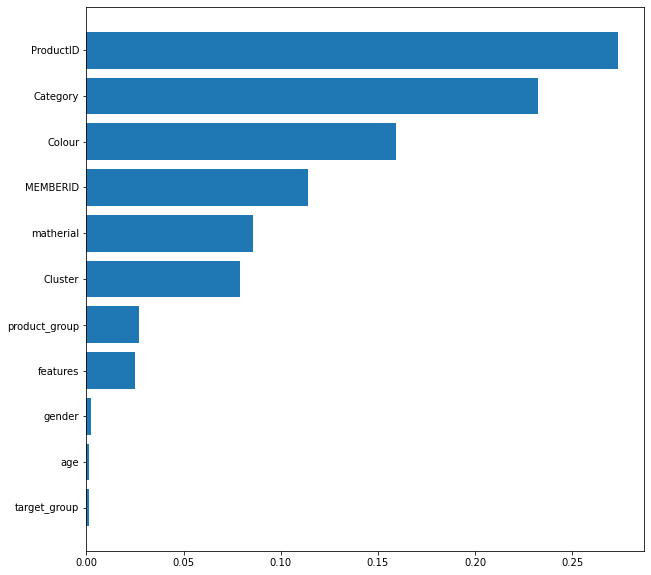

In [ ]:
plt.barh(list(imp.keys()), list(imp.values()), align='center')

In [49]:
userTAB178765=user178765[['ProductID','MEMBERID','gender','age','Colour','matherial','product_group','target_group','features','Category','Cluster']]
userTAB178765

,ProductID,MEMBERID,gender,age,Colour,matherial,product_group,target_group,features,Category,Cluster
0,0,8968,2,0.566667,8,4,0,5,7,0,3
1,1,8968,2,0.566667,2,24,0,5,64,1,20
2,2,8968,2,0.566667,2,2,0,5,14,0,5
3,3,8968,2,0.566667,5,4,5,5,34,4,16
4,4,8968,2,0.566667,8,4,5,5,34,4,16
...,...,...,...,...,...,...,...,...,...,...,...
3172,3297,8968,2,0.566667,9,24,5,5,56,8,11
3173,3298,8968,2,0.566667,8,34,5,5,66,3,28
3174,3299,8968,2,0.566667,2,4,5,5,38,3,28
3175,3300,8968,2,0.566667,5,24,5,5,56,3,15


In [55]:
import matplotlib.pyplot as plt


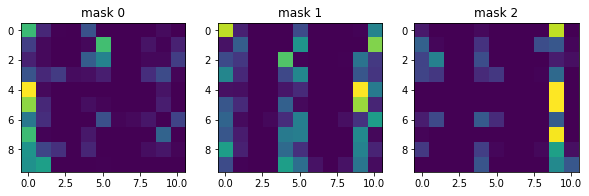

In [56]:
explain_matrix, masks = reg.explain(userTAB178765.values)
fig, axs = plt.subplots(1, 3, figsize=(10,10))

for i in range(3):
    axs[i].imshow(masks[i][:10])
    axs[i].set_title(f"mask {i}")

In [50]:
preds178765['TABNET']=reg.predict(userTAB178765.values)

In [ ]:
preds178765.head()

,gender,age,MEMBERID,ProductID,Colour,matherial,product_group,target_group,features,Category,Cluster,PredsxDeepFM,TABNET
0,2.0,51.0,178765.0,010CA1O304,OTHER,Cotton,Accessories,Women,backpack,Accessories hard,Bags Non-Leather,2.253060,3.220370
1,2.0,51.0,178765.0,010CA1Q302,BLUE,Polyester,Accessories,Women,shawls,Accessories soft,Shawls/Scarves,2.323148,3.112500
2,2.0,51.0,178765.0,010CA1S301,BLUE,Buffalo Split Leather,Accessories,Women,belts cm,Accessories hard,Belts,2.206944,2.699850
3,2.0,51.0,178765.0,010CC1B302,GREY,Cotton,Women,Women,length service,Denim,Pants Denim,1.583255,2.939901
4,2.0,51.0,178765.0,010CC1B305,OTHER,Cotton,Women,Women,length service,Denim,Pants Denim,1.607694,2.143070


In [51]:
userTAB771733=user771733[['ProductID','MEMBERID','gender','age','Colour','matherial','product_group','target_group','features','Category','Cluster']]

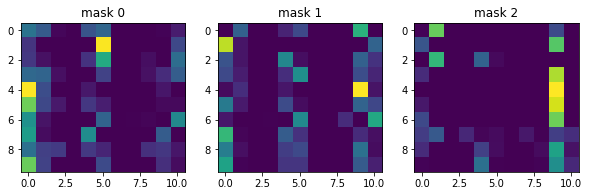

In [57]:
explain_matrix, masks = reg.explain(userTAB771733.values)
fig, axs = plt.subplots(1, 3, figsize=(10,10))

for i in range(3):
    axs[i].imshow(masks[i][:10])
    axs[i].set_title(f"mask {i}")

In [52]:
preds771733['TABNET']=reg.predict(userTAB771733.values)

In [53]:
preds771733.head()

,gender,age,MEMBERID,ProductID,Colour,matherial,product_group,target_group,features,Category,Cluster,PredsxDeepFM,TABNET
0,2.0,42.0,771733.0,010CA1O304,OTHER,Cotton,Accessories,Women,backpack,Accessories hard,Bags Non-Leather,2.737335,4.995235
1,2.0,42.0,771733.0,010CA1Q302,BLUE,Polyester,Accessories,Women,shawls,Accessories soft,Shawls/Scarves,2.690987,3.850037
2,2.0,42.0,771733.0,010CA1S301,BLUE,Buffalo Split Leather,Accessories,Women,belts cm,Accessories hard,Belts,2.557454,3.507605
3,2.0,42.0,771733.0,010CC1B302,GREY,Cotton,Women,Women,length service,Denim,Pants Denim,1.694690,2.068795
4,2.0,42.0,771733.0,010CC1B305,OTHER,Cotton,Women,Women,length service,Denim,Pants Denim,1.722045,2.161431





# XGBOOST

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. We use xgboost on GPU here.

In [58]:
import xgboost as xgb

In [59]:
xg_train = xgb.DMatrix(X_train.values,y_train)
xg_valid = xgb.DMatrix(X_valid.values,y_valid)   

In [60]:
params = {'tree_method': 'gpu_hist', 'max_depth': 10, 'alpha': 0.1, 'subsample': 0.6, 'scale_pos_weight': 1, 'learning_rate': 0.01, 'silent': 1, 'objective':'reg:linear', 'eval_metric': 'rmse','n_gpus': 1}

In [61]:
regXGB = xgb.train(params, xg_train, 1000, evals=[(xg_train, "train"), (xg_valid, "eval")],early_stopping_rounds=5, verbose_eval=True)

[0]	train-rmse:3.68321	eval-rmse:3.70524
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 5 rounds.
[1]	train-rmse:3.65164	eval-rmse:3.67372
[2]	train-rmse:3.62054	eval-rmse:3.64268
[3]	train-rmse:3.5898	eval-rmse:3.61194
[4]	train-rmse:3.5593	eval-rmse:3.58151
[5]	train-rmse:3.5292	eval-rmse:3.55144
[6]	train-rmse:3.49945	eval-rmse:3.5218
[7]	train-rmse:3.47003	eval-rmse:3.49245
[8]	train-rmse:3.44088	eval-rmse:3.46335
[9]	train-rmse:3.41215	eval-rmse:3.43473
[10]	train-rmse:3.38379	eval-rmse:3.40643
[11]	train-rmse:3.35568	eval-rmse:3.37841
[12]	train-rmse:3.32792	eval-rmse:3.35072
[13]	train-rmse:3.30051	eval-rmse:3.32336
[14]	train-rmse:3.27342	eval-rmse:3.29633
[15]	train-rmse:3.24658	eval-rmse:3.26951
[16]	train-rmse:3.22009	eval-rmse:3.2431
[17]	train-rmse:3.1938	eval-rmse:3.2169
[18]	train-rmse:3.16796	eval-rmse:3.19112
[19]	train-rmse:3.14241	eval-rmse:3.16558
[20]	train-rmse:3.1171	eval-rmse:3.

In [ ]:
imps=regXGB.get_score(importance_type="gain")

In [ ]:
mapper = {'f{0}'.format(i): v for i, v in enumerate(X_train.columns)}
mapped = {mapper[k]: v for k, v in imps.items()}
mapped

{'Category': 86.01106266338357,
 'Cluster': 62.58328920975717,
 'Colour': 62.59635477396971,
 'MEMBERID': 6.438786473627468,
 'ProductID': 28.5300310862712,
 'age': 6.448272046050587,
 'features': 28.406104707330893,
 'gender': 5.317592519525576,
 'matherial': 42.912575481483564,
 'product_group': 29.446970483139104,
 'target_group': 26.31013688098456}

In [ ]:
mapped={k: v for k, v in sorted(mapped.items(), key=lambda item: item[1])}

<BarContainer object of 11 artists>

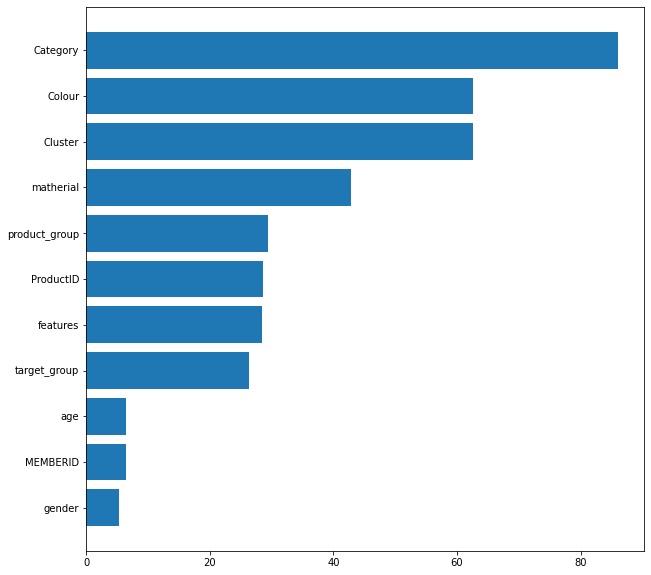

In [ ]:
plt.barh(list(mapped.keys()), list(mapped.values()), align='center')

In [62]:
preds178765['XGBOOST']=regXGB.predict(xgb.DMatrix(userTAB178765.values))

In [63]:
preds178765.head()

,gender,age,MEMBERID,ProductID,Colour,matherial,product_group,target_group,features,Category,Cluster,PredsxDeepFM,TABNET,XGBOOST
0,2.0,51.0,178765.0,010CA1O304,OTHER,Cotton,Accessories,Women,backpack,Accessories hard,Bags Non-Leather,2.237521,3.222044,3.357754
1,2.0,51.0,178765.0,010CA1Q302,BLUE,Polyester,Accessories,Women,shawls,Accessories soft,Shawls/Scarves,2.225422,4.481304,2.631370
2,2.0,51.0,178765.0,010CA1S301,BLUE,Buffalo Split Leather,Accessories,Women,belts cm,Accessories hard,Belts,2.104673,3.699023,3.218219
3,2.0,51.0,178765.0,010CC1B302,GREY,Cotton,Women,Women,length service,Denim,Pants Denim,1.536121,2.612721,2.006189
4,2.0,51.0,178765.0,010CC1B305,OTHER,Cotton,Women,Women,length service,Denim,Pants Denim,1.562388,2.135189,1.997912


In [64]:
preds771733['XGBOOST']=regXGB.predict(xgb.DMatrix(userTAB771733.values))

In [65]:
preds771733.head()

,gender,age,MEMBERID,ProductID,Colour,matherial,product_group,target_group,features,Category,Cluster,PredsxDeepFM,TABNET,XGBOOST
0,2.0,42.0,771733.0,010CA1O304,OTHER,Cotton,Accessories,Women,backpack,Accessories hard,Bags Non-Leather,2.737335,4.995235,3.339263
1,2.0,42.0,771733.0,010CA1Q302,BLUE,Polyester,Accessories,Women,shawls,Accessories soft,Shawls/Scarves,2.690987,3.850037,2.423147
2,2.0,42.0,771733.0,010CA1S301,BLUE,Buffalo Split Leather,Accessories,Women,belts cm,Accessories hard,Belts,2.557454,3.507605,3.074020
3,2.0,42.0,771733.0,010CC1B302,GREY,Cotton,Women,Women,length service,Denim,Pants Denim,1.694690,2.068795,2.013976
4,2.0,42.0,771733.0,010CC1B305,OTHER,Cotton,Women,Women,length service,Denim,Pants Denim,1.722045,2.161431,2.018070


In [66]:
!pip install surprise

     |████████████████████████████████| 11.8MB 262kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617534 sha256=7e11dd7f3a669259b0c1ef1b661db9bf98970f8a70b79bad1f00a675ee00137f
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


# SVD

A latent factor model involving parameter estimation by stochastic gradient descent.

In [67]:
from surprise import SVD,KNNWithMeans
from surprise import Dataset,Reader
from surprise.model_selection import cross_validate

In [68]:
reader = Reader(rating_scale=(0, 15))
data = Dataset.load_from_df(collabFiltering[['MEMBERID', 'ProductID', 'Count']], reader).build_full_trainset()

In [69]:
dataCV = Dataset.load_from_df(collabFiltering[['MEMBERID', 'ProductID', 'Count']], reader)

In [70]:
%%time
algo = SVD(n_factors=50)
algo.fit(data)

CPU times: user 8.1 s, sys: 9.67 ms, total: 8.11 s
Wall time: 8.11 s


In [ ]:
cross_validate(algo, dataCV, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.2679  1.2663  1.2623  1.2655  0.0024  
MAE (testset)     0.8322  0.8293  0.8265  0.8293  0.0023  
Fit time          4.97    4.97    5.01    4.99    0.02    
Test time         0.47    0.47    0.48    0.47    0.01    


{'fit_time': (4.97152304649353, 4.9744813442230225, 5.013360500335693),
 'test_mae': array([0.83217444, 0.82932375, 0.82649174]),
 'test_rmse': array([1.26786387, 1.26630617, 1.26225603]),
 'test_time': (0.4653141498565674, 0.4667832851409912, 0.47748875617980957)}

In [71]:
est771733=[]

In [72]:
x=data.to_inner_uid(771733.0)
uid=data.to_raw_uid(x)
for prod in preds771733['ProductID'].values:
  x=data.to_inner_iid(prod)
  iid=data.to_raw_iid(x)  
  iid = str(prod)  
  pred = algo.predict(uid, iid, verbose=False)
  est771733.append(pred.est)

In [76]:
preds771733['SVD']=est771733

In [ ]:
preds771733.head()

,gender,age,MEMBERID,ProductID,Colour,matherial,product_group,target_group,features,Category,Cluster,PredsxDeepFM,TABNET,XGBOOST,SVD
0,2.0,42.0,771733.0,010CA1O304,OTHER,Cotton,Accessories,Women,backpack,Accessories hard,Bags Non-Leather,2.591115,4.669821,3.406367,3.432931
1,2.0,42.0,771733.0,010CA1Q302,BLUE,Polyester,Accessories,Women,shawls,Accessories soft,Shawls/Scarves,2.679366,2.420033,2.445273,3.162018
2,2.0,42.0,771733.0,010CA1S301,BLUE,Buffalo Split Leather,Accessories,Women,belts cm,Accessories hard,Belts,2.559642,2.765619,3.083060,2.822812
3,2.0,42.0,771733.0,010CC1B302,GREY,Cotton,Women,Women,length service,Denim,Pants Denim,1.665021,2.798069,2.005585,1.503755
4,2.0,42.0,771733.0,010CC1B305,OTHER,Cotton,Women,Women,length service,Denim,Pants Denim,1.688125,2.021320,2.014450,1.695521


In [73]:
est178765=[]

In [74]:
x=data.to_inner_uid(178765.0)
uid=data.to_raw_uid(x)
for prod in preds178765['ProductID'].values:
  x=data.to_inner_iid(prod)
  iid=data.to_raw_iid(x)  
  iid = str(prod)  
  pred = algo.predict(uid, iid, verbose=False)
  est178765.append(pred.est)

In [75]:
preds178765['SVD']=est178765

# FASTAI

Deep learing based method using sigmoid in the output.

In [77]:
! [ -e /content ] && pip install -Uqq fastai 

     |████████████████████████████████| 194kB 5.3MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 


In [78]:
from fastai.tabular.all import *
from fastai.collab import *

In [79]:
dls = CollabDataLoaders.from_df(collabFiltering, bs=512,valid_pct=0.05)
dls.show_batch()

,MEMBERID,ProductID,Count
0,603212,020EE1K309,4
1,399045,040EE1C314,2
2,6.65067e+06,069CC2K029,3
3,790358,050EE1D302,2
4,2.05658e+06,030EE1E306,4
5,2.07586e+06,030EE2B303,3
6,2.54369e+06,040EE1F319,3
7,8.44458e+06,040EE1C307,2
8,1.59278e+06,040EE2K302,3
9,819114,020EE1G315,3


In [80]:
learn = collab_learner(dls, n_factors=64, y_range=(0, 15),use_nn=True,loss_func=MSELossFlat())

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.004365158267319202)

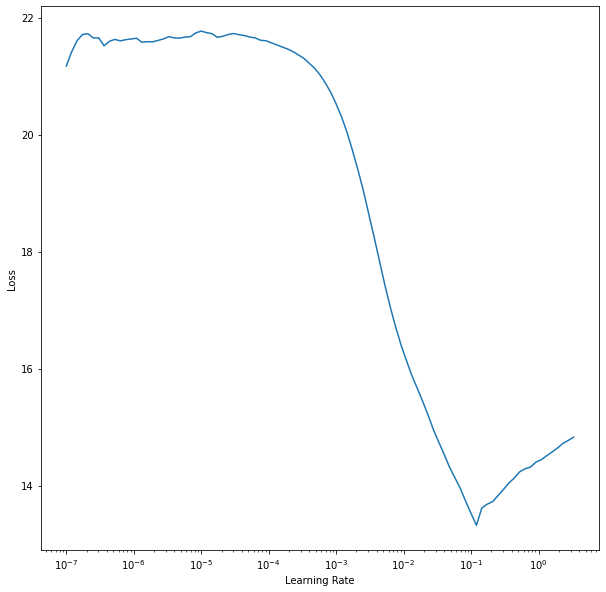

In [ ]:
learn.lr_find()

In [81]:
learn.fit_one_cycle(2, 5e-3, wd=0.1, cbs=[ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=2,factor=0.5,min_lr=1e-6)])

epoch,train_loss,valid_loss,time
0,1.706153,1.658415,00:14
1,1.044258,1.655310,00:14


In [82]:
dl771733=learn.dls.test_dl(preds771733[['MEMBERID','ProductID']])

In [83]:
res771733=learn.get_preds(dl=dl771733)

In [ ]:
res771733

(tensor([[1.8110],
         [1.6873],
         [2.2668],
         ...,
         [2.0824],
         [3.7344],
         [2.0430]]), None)

In [84]:
preds771733['FASTAI']=res771733[0].squeeze().numpy()

In [ ]:
preds771733.head()

,gender,age,MEMBERID,ProductID,Colour,matherial,product_group,target_group,features,Category,Cluster,PredsxDeepFM,TABNET,XGBOOST,SVD,FASTAI
0,2.0,42.0,771733.0,010CA1O304,OTHER,Cotton,Accessories,Women,backpack,Accessories hard,Bags Non-Leather,2.591115,4.669821,3.406367,3.432931,1.811049
1,2.0,42.0,771733.0,010CA1Q302,BLUE,Polyester,Accessories,Women,shawls,Accessories soft,Shawls/Scarves,2.679366,2.420033,2.445273,3.162018,1.687348
2,2.0,42.0,771733.0,010CA1S301,BLUE,Buffalo Split Leather,Accessories,Women,belts cm,Accessories hard,Belts,2.559642,2.765619,3.083060,2.822812,2.266758
3,2.0,42.0,771733.0,010CC1B302,GREY,Cotton,Women,Women,length service,Denim,Pants Denim,1.665021,2.798069,2.005585,1.503755,1.543742
4,2.0,42.0,771733.0,010CC1B305,OTHER,Cotton,Women,Women,length service,Denim,Pants Denim,1.688125,2.021320,2.014450,1.695521,1.496837


In [85]:
dl178765=learn.dls.test_dl(preds178765[['MEMBERID','ProductID']])

In [86]:
res178765=learn.get_preds(dl=dl178765)

In [87]:
preds178765['FASTAI']=res178765[0].squeeze().numpy()

In [ ]:
preds178765.head()

,gender,age,MEMBERID,ProductID,Colour,matherial,product_group,target_group,features,Category,Cluster,PredsxDeepFM,TABNET,XGBOOST,SVD,FASTAI
0,2.0,51.0,178765.0,010CA1O304,OTHER,Cotton,Accessories,Women,backpack,Accessories hard,Bags Non-Leather,2.253060,3.220370,3.414702,2.528516,2.809034
1,2.0,51.0,178765.0,010CA1Q302,BLUE,Polyester,Accessories,Women,shawls,Accessories soft,Shawls/Scarves,2.323148,3.112500,2.658072,2.479034,2.186305
2,2.0,51.0,178765.0,010CA1S301,BLUE,Buffalo Split Leather,Accessories,Women,belts cm,Accessories hard,Belts,2.206944,2.699850,3.202499,2.243059,3.152376
3,2.0,51.0,178765.0,010CC1B302,GREY,Cotton,Women,Women,length service,Denim,Pants Denim,1.583255,2.939901,1.989041,0.944824,1.777302
4,2.0,51.0,178765.0,010CC1B305,OTHER,Cotton,Women,Women,length service,Denim,Pants Denim,1.607694,2.143070,1.998453,0.977214,1.883812


# ENSEMBLE

We combine all model and make prediction in probabilitic sense.

In [88]:
results771733=preds771733[['MEMBERID','ProductID','PredsxDeepFM','TABNET','XGBOOST','SVD','FASTAI']]

In [89]:
results178765=preds178765[['MEMBERID','ProductID','PredsxDeepFM','TABNET','XGBOOST','SVD','FASTAI']]

In [95]:
ens178765=results178765['PredsxDeepFM']*0.3+0.2*results178765['TABNET']+0.2*results178765['XGBOOST']+0.2*results178765['FASTAI']+0.1*results178765['SVD']

In [98]:
mixup178765=preds178765[['MEMBERID','ProductID']].copy()

In [99]:
mixup178765['ENS']=ens178765

In [103]:
prods178765=mixup178765.sort_values(by='ENS',ascending=False)['ProductID'][:20].values

In [104]:
weights178765=mixup178765.sort_values(by='ENS',ascending=False)['ENS'][:20].values/(mixup178765.sort_values(by='ENS',ascending=False)['ENS'][:20].sum())

only sampling from top 20.

In [106]:
np.random.choice(a=prods178765,p=weights178765,size=5)

array(['990EF1A342', '990EF1A338', '990EF1A342', '128EO1E003',
       '990EF1A343'], dtype=object)

In [ ]:
ens178765=ens178765/ens178765.sum()

MEMBER = 178765

Samling from all.

In [ ]:
np.random.choice(a=results178765['ProductID'].values,p=ens178765,size=10)

array(['069EO1E021', '020EO2F304', '088CA1Q005', '060EE1E334',
       '069EF1A022', '040EF7A319', '050EE1F351', '050EE2K354',
       '058EE1K077', '079EI1B014'], dtype=object)

In [107]:
mixup771733=preds771733[['MEMBERID','ProductID']].copy()

In [108]:
ens771733=results771733['PredsxDeepFM']*0.3+0.2*results771733['TABNET']+0.2*results771733['XGBOOST']+0.2*results771733['FASTAI']+0.1*results771733['SVD']

In [109]:
mixup771733['ENS']=ens771733

Only sampling from top 20.

MEMBER = 771733

In [110]:
prods771733=mixup771733.sort_values(by='ENS',ascending=False)['ProductID'][:20].values
weights771733=mixup771733.sort_values(by='ENS',ascending=False)['ENS'][:20].values/(mixup771733.sort_values(by='ENS',ascending=False)['ENS'][:20].sum())
np.random.choice(a=prods771733,p=weights771733,size=5)

array(['990EF1A343', '999EO1B805', '990EF1A342', '999EO1B805',
       '999EF1A836'], dtype=object)

In [ ]:
ens771733=ens771733/ens771733.sum()

sampling from all

In [ ]:
np.random.choice(a=results771733['ProductID'].values,p=ens771733,size=10)

array(['069EA1Q004', '998EF1A824', '050EE2K308', '020EF8A304',
       '040EE2K313', '069EE1B023', '049EF1A092', '030EO1G304',
       '119EG1T007', '099EF1T063'], dtype=object)